# Create a Hillshade from a Terrain Raster in Python 

In this tutorial, we will learn how to create a hillshade from a terrain raster in Python. We will then overlay the hillshade, canopy height model, and digital terrain model to better visulize a tile of the TEAK LiDAR dataset. 

First, let's import the required packages and set plot display to inline:

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

We also need to load the `neon_aop_lidar_raster_functions` module that you downloaded in Lesson 1. 

In [2]:
# %load neon_aop_lidar_raster_functions
import gdal, osr 
import numpy as np

def raster2array(geotif_file):
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

Modify the plot_band_array function to enable transparency, using the variable alpha, which ranges from 0 (transparent) to 1 (opaque).

In [3]:
def plot_band_array(band_array,refl_extent,title,cbar_label,colormap='spectral',alpha=1):
    plt.imshow(band_array,extent=refl_extent,alpha=alpha); 
    cbar = plt.colorbar(); plt.set_cmap(colormap); 
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

###  Calculate Hillshade

<img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade_files/image001.gif" style="width: 250px;"/>
<center><font size="2">http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade.htm</font></center>


Hillshade is used to visualize the hypothetical illumination value (from 0-255) of each pixel on a surface given a specified light source. To calculate hillshade, we need the zenith (altitude) and azimuth of the illumination source, as well as the slope and aspect of the terrain. The formula for hillshade is:

$$Hillshade = 255.0 * (( cos(zenith_I)*cos(slope_T))+(sin(zenith_I)*sin(slope_T)*cos(azimuth_I-aspect_T))$$

Where all angles are in radians. 

For more information about how hillshades work, refer to the ESRI ArcGIS Help page: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm. 

We can define a hillshade function. The function below comes from the following github repo:

https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py

In [4]:
def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

Now that we have a function to generate hillshade, we need to read in the NEON LiDAR Digital Terrain Model (DTM) geotif using the ```raster2array``` function and then calculate hillshade using the ```hillshade``` function. We can then plot both using the ```plot_band_array``` function. 

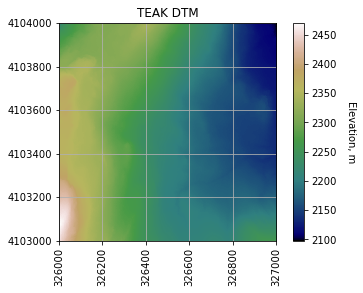

In [5]:
# Use raster2array to convert TEAK DTM Geotif to array & plot
teak_dtm_array, teak_dtm_md = raster2array('../data/TEAK/lidar/2013_TEAK_1_326000_4103000_DTM.tif')
plot_band_array(teak_dtm_array,teak_dtm_md['extent'],'TEAK DTM','Elevation, m',colormap='gist_earth')
ax = plt.gca(); plt.grid('on')

Use the hillshade function on the TEAK DTM array, with an aspect of 225° and 80% opacity.

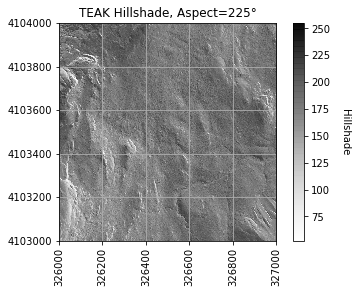

In [6]:
# Use hillshade function on a DTM Geotiff
teak_hillshade_array = hillshade(teak_dtm_array,225,45)
plot_band_array(teak_hillshade_array,teak_dtm_md['extent'],'TEAK Hillshade, Aspect=225°',
                'Hillshade',colormap='Greys',alpha=0.8)
ax = plt.gca(); plt.grid('on') 

Next, overlay this transparent hillshade on the DTM:

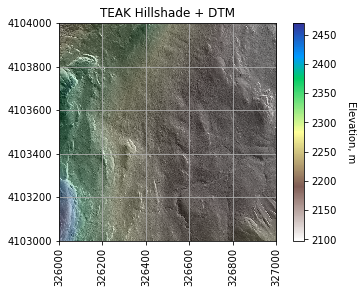

In [7]:
fig = plt.figure(frameon=False)
im1 = plt.imshow(teak_dtm_array,cmap='terrain_r',extent=teak_dtm_md['extent']); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(teak_hillshade_array,cmap='Greys',alpha=0.8,extent=teak_dtm_md['extent']); 
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK Hillshade + DTM')

### Calculate CHM & Overlay on Top of Hillshade

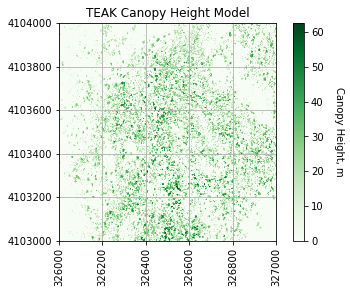

In [8]:
#Calculate CHM from DSM & DTM:
teak_dsm_array, teak_dsm_md = raster2array('../data/TEAK/lidar/2013_TEAK_1_326000_4103000_DSM.tif')
teak_chm_array = teak_dsm_array - teak_dtm_array;

plot_band_array(teak_chm_array,teak_dtm_md['extent'],'TEAK Canopy Height Model', \
                'Canopy Height, m',colormap='Greens')
ax = plt.gca(); plt.grid('on')

Overlay the transparent hillshade, canophy height model, and DTM:

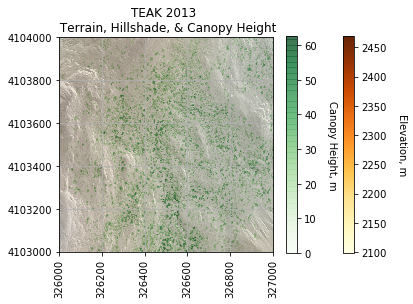

In [9]:
fig = plt.figure(frameon=False)

#Terrain
im1 = plt.imshow(teak_dtm_array,cmap='YlOrBr',extent=teak_dtm_md['extent']); 
cbar1 = plt.colorbar(); cbar1.set_label('Elevation, m',rotation=270,labelpad=20)

#Hillshade
im2 = plt.imshow(teak_hillshade_array,cmap='Greys',alpha=.8,extent=teak_dtm_md['extent']);

#Canopy
im3 = plt.imshow(teak_chm_array,cmap='Greens',alpha=0.5,extent=teak_dtm_md['extent']); 
cbar2 = plt.colorbar(); cbar2.set_label('Canopy Height, m',rotation=270,labelpad=20)

ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK 2013 \n Terrain, Hillshade, & Canopy Height')

## Referenced Webpages:

http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture11/concepts/Hillshade.htm

https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py

http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm